# Data Exploration and Feature Creation

In [25]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("fun")

In [26]:
# Read data
df = pd.read_csv("data/flattened_data.csv")
df["became_member_on"] = pd.to_datetime(df["became_member_on"])
df.head()

,customer_id,offer_id,offer_type,email,mobile,social,web,difficulty,reward,duration,...,time_transaction,time_completed,time_expired,gender,age,became_member_on,income,year,month,day
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,576.0,576.0,744,M,33,2017-04-21,72000.0,2017,4,21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,1,0,1,0,0,4,...,414.0,NaN,432,M,33,2017-04-21,72000.0,2017,4,21
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,1,0,0,0,3,...,228.0,NaN,240,M,33,2017-04-21,72000.0,2017,4,21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,5,5,5,...,414.0,414.0,528,M,33,2017-04-21,72000.0,2017,4,21
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1,10,2,10,...,528.0,528.0,744,M,33,2017-04-21,72000.0,2017,4,21


## Data Exploration

#### What are the offers?

In [27]:
df.groupby("offer_id").count().iloc[:,-1]

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
Name: day, dtype: int64

In [28]:
offers = df[["offer_id", "offer_type", "email", "mobile", "social", "web", "difficulty", "duration", "reward"]].drop_duplicates()

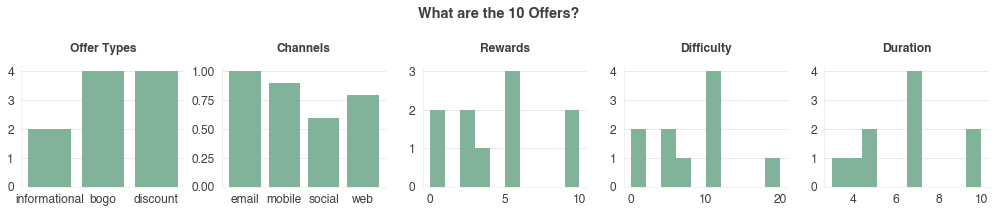

In [29]:
fig, axes = plt.subplots(1, 5, figsize=[14,3])
fig.suptitle("What are the 10 Offers?")

p = offers.groupby("offer_type").count().sort_values(by=offers.columns[-1])
axes[0].set_title("Offer Types")
axes[0].bar(x=p.index, height=p.iloc[:,0])

p = offers[["email", "mobile", "social", "web"]].stack().reset_index()
p = p.groupby("level_1").mean()
axes[1].set_title("Channels")
axes[1].bar(x=p.index, height=p.iloc[:,-1])

axes[2].set_title("Rewards")
axes[2].hist(offers.reward)

axes[3].set_title("Difficulty")
axes[3].hist(offers.difficulty)

axes[4].set_title("Duration")
axes[4].hist(offers.duration)

plt.show()

* There are 4 BOGO, 4 discount, and 2 informational offers.
* Email is always the channel for sending offers. Mobile, web and social are also used in that order of frequency.
* Rewards are under \\$10. Most are around or just under \\$5.
* Most offers require spending \\$10 for a reward.
* Most offers last a week. The longest is 1.5 weeks.

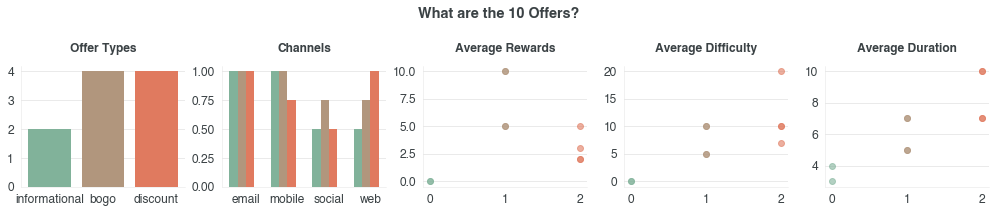

In [30]:
width = 0.2
offer_types_group = offers.groupby("offer_type").count().sort_values(by=offers.columns[-1])
offer_types = offer_types_group.index

fig, axes = plt.subplots(1, 5, figsize=[14,3])
fig.suptitle("What are the 10 Offers?")

axes[0].set_title("Offer Types")
axes[0].set_xticks(np.arange(len(offer_types)))
axes[0].set_xticklabels(offer_types)

axes[1].set_title("Channels")
axes[1].set_xticks(np.arange(4))
axes[1].set_xticklabels(["email", "mobile", "social", "web"])

axes[2].set_title("Average Rewards")
axes[3].set_title("Average Difficulty")
axes[4].set_title("Average Duration")
for i, label in enumerate(offer_types):
    
    # Filter data
    p = offers[offers.offer_type == label]
    
    axes[0].bar(x=i, height=p.shape[0])

    q = p[["email", "mobile", "social", "web"]].stack().reset_index().groupby("level_1").mean()
    axes[1].bar(x=np.arange(4) + i*width - 1.5*width, height=q.iloc[:,-1], width=width, label=label)

    axes[2].scatter(x=np.ones(p.shape[0]) * i, y=p.reward, label=label, alpha=0.6)
    axes[3].scatter(x=np.ones(p.shape[0]) * i, y=p.difficulty, label=label, alpha=0.6)
    axes[4].scatter(x=np.ones(p.shape[0]) * i, y=p.duration, label=label, alpha=0.6)

plt.show()

* Informational offers have no difficulty or reward. They are literally informational.
* BOGO has the highest rewards among the offers. You spend \\$10 to get \\$10 or \\$5 to get \\$5. BOGO usually lasts 1 week.
* Discounts have a higher average difficulty, lower rewards (20-50% off), and duration of over a week.

In [31]:
offers[["difficulty", "duration", "reward"]].corr().style.background_gradient(cmap='coolwarm')

,difficulty,duration,reward
difficulty,1.000000,0.808414,0.465686
duration,0.808414,1.000000,0.160262
reward,0.465686,0.160262,1.000000


* Offers with higher difficulty have higher duration (correlation of 80%).

#### Who are the customers?

In [32]:
customers = df[["customer_id", "gender", "age", "became_member_on", "income", "year", "month", "day"]].drop_duplicates()

In [33]:
customers[["income", "age"]].describe()

,income,age
count,14820.000000,16994.000000
mean,65406.882591,62.526656
std,21598.059614,26.738768
min,30000.000000,18.000000
25%,49000.000000,45.000000
50%,64000.000000,58.000000
75%,80000.000000,73.000000
max,120000.000000,118.000000


* Most customers are between 50 and 60 years old.
* Average income is \\$65K.

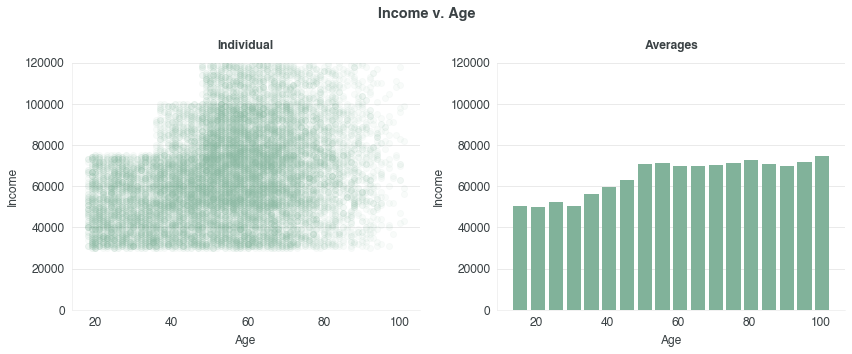

In [34]:
fig, axes = plt.subplots(1, 2, figsize=[12,5])

fig.suptitle("Income v. Age")

axes[0].set_title("Individual")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Income")
axes[0].set_ylim(0, customers.income.max())
axes[0].scatter(customers.age, customers.income, alpha=0.05)

axes[1].set_title("Averages")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Income")
axes[1].set_ylim(0, customers.income.max())
customers["age_group"] = customers.age.map(lambda x: x//5*5)
p = customers.groupby("age_group").mean().income
axes[1].bar(p.index + 0.5, p, width=4)

plt.show()

* This is definitely not representative of all types of Starbucks customers. In this dataset, all customers make between \\$30K and \\$120K.
* Customers under 35 years old make around \\$50K. Customers between 35 and 50 increase their income as they get older overall. Customers at 50 years or older make around \\$70K.
* The trend is as you get older, you make more money and the variation is wider.
* There are fewer customers 80 years and older.

<BarContainer object of 3 artists>

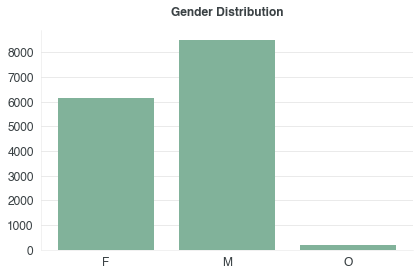

In [35]:
fig, ax = plt.subplots()

ax.set_title("Gender Distribution")
p = customers.groupby("gender").count()
ax.bar(p.index, p.iloc[:, -1])

In [36]:
customers.groupby("gender").mean()[["age", "income"]]

,age,income
gender,,
F,57.542204,71315.591837
M,52.112107,61193.563598
O,54.400943,63287.735849


* Females are slightly older and have more income than males. They make up a smaller group than males.

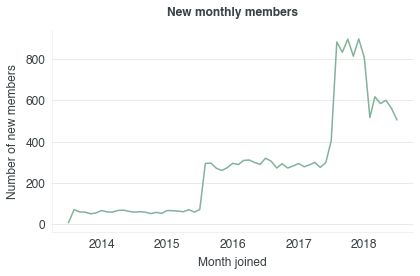

In [37]:
fig, ax = plt.subplots()

customers["ym"] = customers["became_member_on"].to_numpy().astype("datetime64[M]")
p = customers.groupby("ym").count().reset_index()
ax.plot(p.ym, p.iloc[:,-1])
ax.set_ylabel("Number of new members")
ax.set_xlabel("Month joined")
ax.set_title("New monthly members")
plt.show()

* Membership increases over time, but there was a dip in 2018. It increases significantly every 2 years.

#### How do customers respond to offers?

In [38]:
# Create flags
df["viewed_flag"] = df.time_viewed.map(lambda x: 1 if x > 0 else 0)
df["completed_flag"] = df.time_completed.map(lambda x: 1 if x > 0 else 0)
df["viewed_completed_flag"] = df.apply(lambda x: 1 if x.viewed_flag == 1 and x.completed_flag == 1 and x.time_viewed <= x.time_completed else 0, axis=1)

In [39]:
df

,customer_id,offer_id,offer_type,email,mobile,social,web,difficulty,reward,duration,...,gender,age,became_member_on,income,year,month,day,viewed_flag,completed_flag,viewed_completed_flag
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,M,33,2017-04-21,72000.0,2017,4,21,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,1,0,1,0,0,4,...,M,33,2017-04-21,72000.0,2017,4,21,1,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,1,0,0,0,3,...,M,33,2017-04-21,72000.0,2017,4,21,1,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,5,5,5,...,M,33,2017-04-21,72000.0,2017,4,21,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1,10,2,10,...,M,33,2017-04-21,72000.0,2017,4,21,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,F,45,2016-11-25,62000.0,2016,11,25,1,1,1
76273,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,F,45,2016-11-25,62000.0,2016,11,25,1,1,1
76274,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,F,45,2016-11-25,62000.0,2016,11,25,1,1,0
76275,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,0,1,5,5,7,...,F,45,2016-11-25,62000.0,2016,11,25,1,1,0


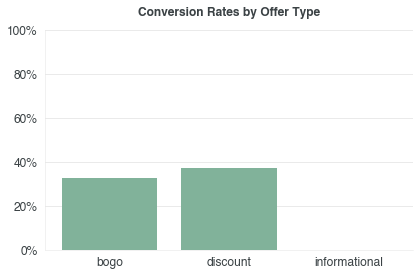

In [40]:
fig, ax = plt.subplots()
ax.set_title("Conversion Rates by Offer Type")

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .2))
ax.set_yticklabels([f"{round(100*x)}%" for x in np.arange(0, 1.1, .2)])

p = df.groupby("offer_type").viewed_completed_flag.mean().reset_index()
ax.bar(x=p["offer_type"], height=p.viewed_completed_flag)

plt.show()

* There's no `offer_completed` event for `informational` offers. Sending out informational offers does not have an explicit monetary "loss" (unlike discounts/BOGO where you don't net the full revenue amount). The indirect monetary loss it has is when a customer uninstalls the app, unsubscribes from notifications, or deletes their membership account. 
* If we want to predict **what is the best type of offer to send to a customer**, we should still include `informational` offers as an option. The proxy to count conversion rates for informational is to check if a customer has viewed and made a transaction during the informational offer's time window.

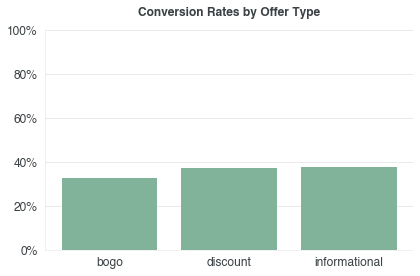

In [41]:
# Informational offer's time_completed is null because the data doesn't have "offer completed" events for this offer type
# Overwrite time_completed with a timestamp for when a customer purchases during the offer time window
# Then recalculate conversion rate
df["time_completed"] = df.apply(lambda x: x.time_transaction if x.offer_type == "informational" and x.time_viewed != np.nan else x.time_completed, axis=1)
df["completed_flag"] = df.time_completed.map(lambda x: 1 if x > 0 else 0)
df["viewed_completed_flag"] = df.apply(lambda x: 1 if x.viewed_flag == 1 and x.completed_flag == 1 and x.time_viewed <= x.time_completed else 0, axis=1)

fig, ax = plt.subplots()
ax.set_title("Conversion Rates by Offer Type")

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .2))
ax.set_yticklabels([f"{round(100*x)}%" for x in np.arange(0, 1.1, .2)])

p = df.groupby("offer_type").viewed_completed_flag.mean().reset_index()
ax.bar(x=p["offer_type"], height=p.viewed_completed_flag)

plt.show()

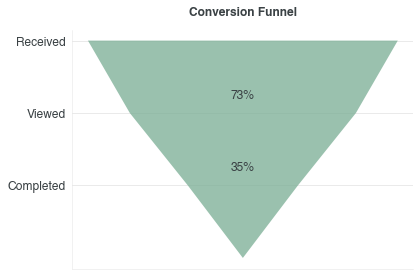

In [42]:
fig, ax = plt.subplots()

y = np.arange(4, 0, -1)
x = [
    df.shape[0],
    df.viewed_flag.sum(),
    df.viewed_completed_flag.sum(),
    0
]

ax.fill_betweenx(y=y, x1=x, x2=[-1*ele for ele in x], alpha=0.8)

ax.set_title("Conversion Funnel")

ax.set_xticks([])
ax.set_yticks([2, 3, 4])
ax.set_yticklabels(["Completed", "Viewed", "Received"])

ax.text(0, 2.2, str(round(100 * df.viewed_completed_flag.mean())) + "%", ha="center")
ax.text(0, 3.2, str(round(100 * df.viewed_flag.mean())) + "%", ha="center")
plt.show()

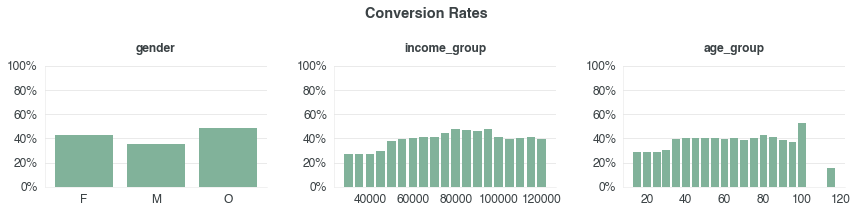

In [43]:
fig, axes = plt.subplots(1, 3, figsize=[12,3])
fig.suptitle("Conversion Rates")

df["age_group"] = df.age.map(lambda x: x//5*5)
df["income_group"] = df.income.map(lambda x: x//5000*5000)

columns = ["gender", "income_group", "age_group"]
for i, c in enumerate(columns):
    ax = axes[i]
    ax.set_title(c)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, .2))
    ax.set_yticklabels([f"{round(100*x)}%" for x in np.arange(0, 1.1, .2)])
    
    if c == "income_group":
        width = 5000*.8
    elif c == "age_group":
        width = 5*.8
    else:
        width = 1*.8
    p = df.groupby(c).viewed_completed_flag.mean().reset_index()
    ax.bar(x=p[c], height=p.viewed_completed_flag, width=width)

* Customers with higher income have a higher conversion rate.
* Since age is correlated with income, older customers also have a higher conversion rate.
* Females also have a higher conversion rate.

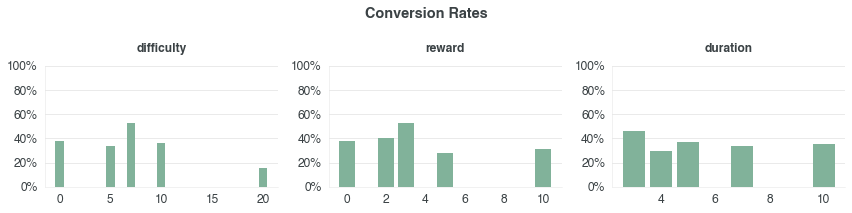

In [44]:
fig, axes = plt.subplots(1, 3, figsize=[12,3])
fig.suptitle("Conversion Rates")

df["age_group"] = df.age.map(lambda x: x//5*5)
df["income_group"] = df.income.map(lambda x: x//5000*5000)

columns = ["difficulty", "reward", "duration"]
for i, c in enumerate(columns):
    ax = axes[i]
    ax.set_title(c)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, .2))
    ax.set_yticklabels([f"{round(100*x)}%" for x in np.arange(0, 1.1, .2)])
    
    p = df.groupby(c).viewed_completed_flag.mean().reset_index()
    ax.bar(x=p[c], height=p.viewed_completed_flag)

* Higher difficulty has lower conversion rate.

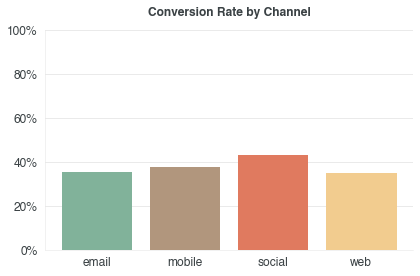

In [45]:
fig, ax = plt.subplots()
ax.set_title("Conversion Rate by Channel")
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, .2))
ax.set_yticklabels([f"{round(100*x)}%" for x in np.arange(0, 1.1, .2)])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["email", "mobile", "social", "web"])
for i, channel in enumerate(["email", "mobile", "social", "web"]):
    p = df[df[channel]==1]
    ax.bar(x=i, height=p.viewed_completed_flag.mean())

* Even though social is not always used, it is more effective.

In [46]:
# Did the customer continue spending after completing the offer?
# Note that a customer could continue spending if they are trying to complete an additional offer
(
    df[(df.is_last_transaction == 1)&(df.offer_type!="informational")].viewed_completed_flag.sum()
    / df[df.offer_type!="informational"].viewed_completed_flag.sum()
)

0.28401368514786524

* Only 28% of customers that completed an offer will continue to spend

In [47]:
df.groupby("viewed_completed_flag")[["spend_amount", "number_transactions"]].mean()

,spend_amount,number_transactions
viewed_completed_flag,,
0,19.736820,1.667005
1,28.872421,1.506869


* Customers who complete their offer spend more per order, but they don't increase their order frequency

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            76277 non-null  object        
 1   offer_id               76277 non-null  object        
 2   offer_type             76277 non-null  object        
 3   email                  76277 non-null  int64         
 4   mobile                 76277 non-null  int64         
 5   social                 76277 non-null  int64         
 6   web                    76277 non-null  int64         
 7   difficulty             76277 non-null  int64         
 8   reward                 76277 non-null  int64         
 9   duration               76277 non-null  int64         
 10  spend_amount           59952 non-null  float64       
 11  number_transactions    76277 non-null  int64         
 12  is_last_transaction    76277 non-null  int64         
 13  t

## Feature Creation

**Creating features for transaction history:**
* Drop features that can't be used to **predict** a customer response. This will be any transaction-related columns, like `spend_amount`, `number_transactions`, and `is_last_transaction`.
* If we do want to use transaction history for our model, a more realistic approach would be to look at the customer's purchase history **before** the time the offer was given. We can create features like `prior_conversion`, `prior_completed`, `prior_number_transactions`, and `avg_spend_amt`.

In [49]:
import sqlite3
pd.options.mode.chained_assignment = None

In [50]:
# Reload and process transaction data (from part 1)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript.rename(columns={"person": "customer_id"}, inplace=True)
transcript["keys"] = transcript.value.map(lambda x: str(list(x.keys())))

received = transcript[transcript.event == "offer received"]
received["offer_id"] = received.value.map(lambda x: x.get("offer id"))
received.drop(columns=["value", "keys", "event"], inplace=True)

completed = transcript[transcript.event == "offer completed"]
completed["offer_id"] = completed.value.map(lambda x: x.get("offer_id"))
completed["reward"] = completed.value.map(lambda x: x.get("reward"))
completed.drop(columns=["value", "keys", "event"], inplace=True)

transaction = transcript[transcript.event == "transaction"]
transaction["amount"] = transaction.value.map(lambda x: x.get("amount"))
transaction.drop(columns=["value", "keys", "event"], inplace=True)

conn = sqlite3.connect(':memory:')
received.to_sql('received', conn, index=False)
completed.to_sql('completed', conn, index=False)
transaction.to_sql('orders', conn, index=False)

In [51]:
query = """
SELECT
    customer_id,
    time,
    count() over(partition by customer_id order by time
        rows between unbounded preceding and current row) as prior_received
FROM received
"""
received = pd.read_sql_query(query, conn)
received.head()

,customer_id,time,prior_received
0,0009655768c64bdeb2e877511632db8f,168,1
1,0009655768c64bdeb2e877511632db8f,336,2
2,0009655768c64bdeb2e877511632db8f,408,3
3,0009655768c64bdeb2e877511632db8f,504,4
4,0009655768c64bdeb2e877511632db8f,576,5


In [52]:
query = """
SELECT
    customer_id,
    time,
    count() over(partition by customer_id order by time
        rows between unbounded preceding and current row) as prior_completed
FROM completed
"""
completed = pd.read_sql_query(query, conn)
completed.head()

,customer_id,time,prior_completed
0,0009655768c64bdeb2e877511632db8f,414,1
1,0009655768c64bdeb2e877511632db8f,528,2
2,0009655768c64bdeb2e877511632db8f,576,3
3,0011e0d4e6b944f998e987f904e8c1e5,252,1
4,0011e0d4e6b944f998e987f904e8c1e5,576,2


In [53]:
query = """
SELECT
    customer_id,
    time,
    count() over(partition by customer_id order by time
        rows between unbounded preceding and current row) as prior_number_transactions,
    sum(amount) over(partition by customer_id order by time
        rows between unbounded preceding and current row) as prior_spend_amt
FROM orders
"""
orders = pd.read_sql_query(query, conn)
orders.head()

,customer_id,time,prior_number_transactions,prior_spend_amt
0,0009655768c64bdeb2e877511632db8f,228,1,22.16
1,0009655768c64bdeb2e877511632db8f,414,2,30.73
2,0009655768c64bdeb2e877511632db8f,528,3,44.84
3,0009655768c64bdeb2e877511632db8f,552,4,58.40
4,0009655768c64bdeb2e877511632db8f,576,5,68.67


In [54]:
# Join to dataset on customer_id and time (time_received)
df = pd.merge(df, received, left_on=["customer_id", "time_received"], right_on=["customer_id", "time"], how="left")
df = pd.merge(df, completed, left_on=["customer_id", "time_received"], right_on=["customer_id", "time"], how="left")
df = pd.merge(df, orders, left_on=["customer_id", "time_received"], right_on=["customer_id", "time"], how="left")

In [55]:
df["conversion_rate"] = df["prior_completed"] / df["prior_received"]
df["conversion_rate"] = df["conversion_rate"].fillna(0)
df["prior_received"] = df["prior_received"].fillna(0)
df["prior_completed"] = df["prior_completed"].fillna(0)
df["avg_spend_amt"] = df["prior_spend_amt"] / df["prior_number_transactions"]
df["avg_spend_amt"] = df["avg_spend_amt"].fillna(0)
df["prior_number_transactions"] = df["prior_number_transactions"].fillna(0)
df["prior_spend_amt"] = df["prior_spend_amt"].fillna(0)

In [56]:
df.head(2)

,customer_id,offer_id,offer_type,email,mobile,social,web,difficulty,reward,duration,...,income_group,time_x,prior_received,time_y,prior_completed,time,prior_number_transactions,prior_spend_amt,conversion_rate,avg_spend_amt
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,70000.0,576,5,576.0,3.0,576.0,5.0,68.67,0.6,13.734
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,1,0,1,0,0,4,...,70000.0,336,2,NaN,0.0,NaN,0.0,0.00,0.0,0.000


**Creating features for offer type and customer profile:**
* Make the `label` binary for whether a customer will complete an offer.
* Change `became_member_on` datetype to `months_as_member`
* Encode `gender` and `offer_type` using one hot encoding
* Use mean imputation for records that still have missing data (this is only the `income` column). Since `StandardScaler` scales based on the mean, missing records will be replaced with the average income.
* Normalize and standardize other columns for better model accuracy

In [57]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import seaborn as sns

In [58]:
df["label"] = df["viewed_completed_flag"]

In [59]:
# This section is removed because it not historical

# # Normalize times so that t=0 when offer is received
# df["time_to_view"] = df["time_viewed"] - df["time_received"]
# df["time_to_view_complete"] = df["time_completed"] - df["time_viewed"]  # Negative values means they viewed AFTER completing
# df["time_to_complete"] = df["time_completed"] - df["time_received"]

# # Fill missing
# df["time_to_view"] = df["time_to_view"].fillna(-1)
# df["time_to_view_complete"] = df["time_to_view_complete"].fillna(0)
# df["time_to_complete"] = df["time_to_complete"].fillna(-1)

In [60]:
# Change became_member_on to months_as_member
df["months_as_member"] = (datetime.now() - df.became_member_on) / np.timedelta64(1, 'M')

In [61]:
# Encode gender
df["gender"] = df["gender"].fillna("missing_gender")  # Fill in missing

le = LabelEncoder()
df["gender_cat"] = le.fit_transform(df["gender"])

name_mapping = df[["gender", "gender_cat"]].drop_duplicates().set_index("gender_cat")

ohe = OneHotEncoder()
genders = pd.DataFrame(ohe.fit_transform(df[["gender_cat"]]).toarray())
genders.rename(columns={i: name_mapping.loc[i, "gender"] for i in np.arange(4)}, inplace=True)

df = pd.concat([df.reset_index().drop(columns=["index"]), genders], axis=1)

df.head(2)

,customer_id,offer_id,offer_type,email,mobile,social,web,difficulty,reward,duration,...,prior_spend_amt,conversion_rate,avg_spend_amt,label,months_as_member,gender_cat,F,M,O,missing_gender
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,68.67,0.6,13.734,0,50.004027,1,0.0,1.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,1,0,1,0,0,4,...,0.00,0.0,0.000,1,50.004027,1,0.0,1.0,0.0,0.0


In [62]:
# Encode offer
le = LabelEncoder()
df["offer_type_cat"] = le.fit_transform(df["offer_type"])

offer_mapping = df[["offer_type", "offer_type_cat"]].drop_duplicates().set_index("offer_type_cat")

ohe = OneHotEncoder()
offers_cat = pd.DataFrame(ohe.fit_transform(df[["offer_type_cat"]]).toarray())
offers_cat.rename(columns={i: offer_mapping.loc[i, "offer_type"] for i in np.arange(3)}, inplace=True)

df = pd.concat([df.reset_index().drop(columns=["index"]), offers_cat], axis=1)

df.head(2)

,customer_id,offer_id,offer_type,email,mobile,social,web,difficulty,reward,duration,...,months_as_member,gender_cat,F,M,O,missing_gender,offer_type_cat,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1,10,2,7,...,50.004027,1,0.0,1.0,0.0,0.0,1,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,1,0,1,0,0,4,...,50.004027,1,0.0,1.0,0.0,0.0,2,0.0,0.0,1.0


In [63]:
df["income"] = df["income"].replace(np.NaN, df["income"].mean())

In [64]:
# Normalize and standardize
scaler = StandardScaler()
normalize_columns = [
    # Customer info
    "income",
    "age",
    "months_as_member",
    # Offer info
    "reward",
    "difficulty",
    "duration",
    "prior_received",
    "prior_completed",
    "prior_number_transactions",
    "prior_spend_amt",
    "avg_spend_amt",
]

for c in normalize_columns:
    df[c] = scaler.fit_transform(df[[c]])

In [65]:
# Get columns for training/test
columns = [
    # Customer info
    "income",
    "age",
    "months_as_member",
    "F",
    "M",
    "O",
    # Offer info
    "reward",
    "difficulty",
    "duration",
    "bogo",
    "discount",
    # Prior history 
    "prior_received",
    "prior_completed",
    "prior_number_transactions",
    "prior_spend_amt",
    "avg_spend_amt",
]
data = df[["label"] + columns]

In [66]:
data

,label,income,age,months_as_member,F,M,O,reward,difficulty,duration,bogo,discount,prior_received,prior_completed,prior_number_transactions,prior_spend_amt,avg_spend_amt
0,0,0.325432,-1.104099,-0.136705,0.0,1.0,0.0,-0.649063,0.413895,0.224520,0.0,1.0,1.459160,5.782764,2.366137,1.940499,2.071115
1,1,0.325432,-1.104099,-0.136705,0.0,1.0,0.0,-1.237670,-1.394431,-1.139357,0.0,0.0,-0.603445,-0.171986,-0.230146,-0.166311,-0.163542
2,1,0.325432,-1.104099,-0.136705,0.0,1.0,0.0,-1.237670,-1.394431,-1.593983,0.0,0.0,-1.290980,-0.171986,-0.230146,-0.166311,-0.163542
3,0,0.325432,-1.104099,-0.136705,0.0,1.0,0.0,0.233848,-0.490268,-0.684732,1.0,0.0,0.084090,-0.171986,-0.230146,-0.166311,-0.163542
4,0,0.325432,-1.104099,-0.136705,0.0,1.0,0.0,-0.649063,0.413895,1.588397,0.0,1.0,0.771625,-0.171986,-0.230146,-0.166311,-0.163542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76663,1,-0.169482,-0.655132,0.220511,1.0,0.0,0.0,-0.649063,0.413895,0.224520,0.0,1.0,0.084090,-0.171986,-0.230146,-0.166311,-0.163542
76664,1,-0.169482,-0.655132,0.220511,1.0,0.0,0.0,-0.649063,0.413895,0.224520,0.0,1.0,0.771625,-0.171986,-0.230146,-0.166311,-0.163542
76665,0,-0.169482,-0.655132,0.220511,1.0,0.0,0.0,-0.649063,0.413895,0.224520,0.0,1.0,2.146695,11.737513,6.520191,5.878919,2.302639
76666,0,-0.169482,-0.655132,0.220511,1.0,0.0,0.0,0.233848,-0.490268,0.224520,1.0,0.0,1.459160,9.752597,6.000934,5.442340,2.315207


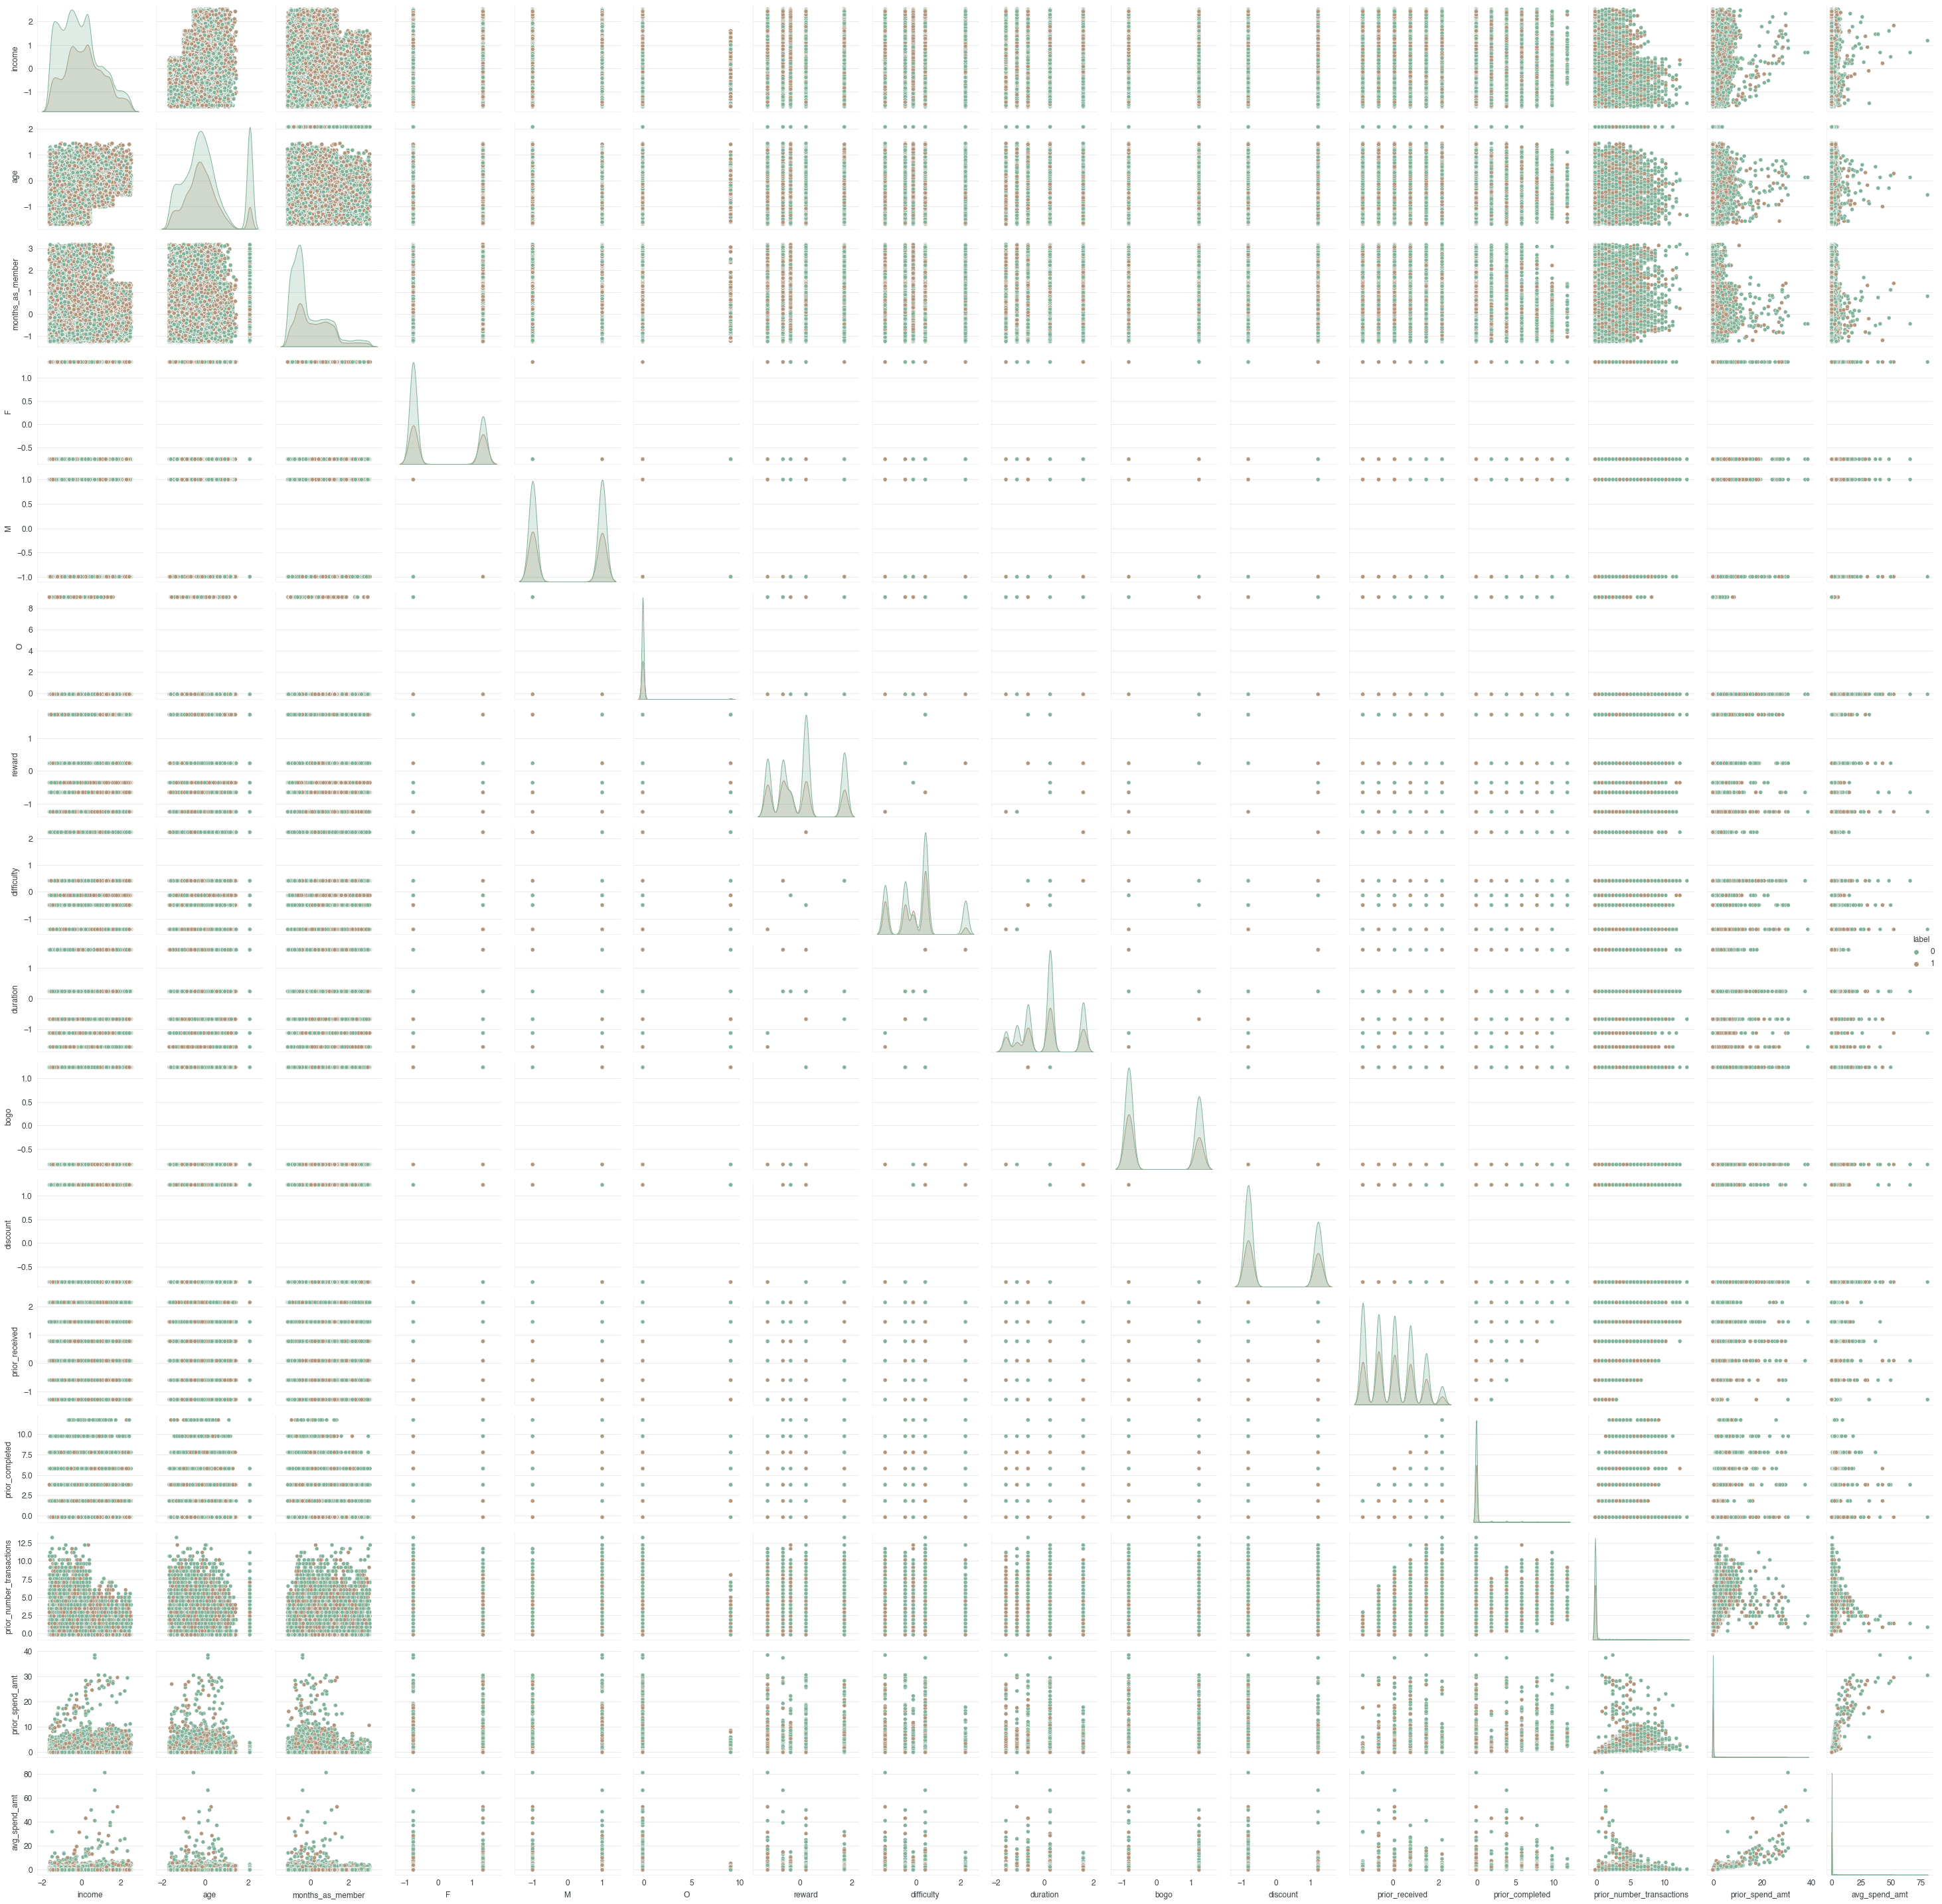

In [167]:
sns.pairplot(data, hue="label")
plt.show()

In [67]:
data.corr()

,label,income,age,months_as_member,F,M,O,reward,difficulty,duration,bogo,discount,prior_received,prior_completed,prior_number_transactions,prior_spend_amt,avg_spend_amt
label,1.000000,0.106964,-0.096218,0.136270,0.115226,-0.009484,0.029459,-0.076694,-0.105626,-0.032742,-0.048033,0.028965,0.009549,-0.016983,-0.015499,-0.001158,-0.003294
income,0.106964,1.000000,0.185770,0.021737,0.217967,-0.206648,-0.012285,0.002168,-0.000229,-0.001538,0.002054,-0.001380,-0.001926,0.055734,-0.056461,0.042014,0.069620
age,-0.096218,0.185770,1.000000,-0.018997,-0.141097,-0.387513,-0.031920,-0.000875,-0.004762,-0.005613,0.002163,-0.003844,-0.000194,-0.030535,-0.036888,-0.035773,-0.027259
months_as_member,0.136270,0.021737,-0.018997,1.000000,-0.006999,0.029918,-0.011819,0.002593,0.001542,0.000416,0.002468,-0.004083,0.001315,0.031646,0.094246,0.043109,0.027458
F,0.115226,0.217967,-0.141097,-0.006999,1.000000,-0.750523,-0.082998,0.000121,0.000241,-0.001925,0.000065,-0.002446,-0.001162,0.052041,-0.004642,0.039793,0.045652
M,-0.009484,-0.206648,-0.387513,0.029918,-0.750523,1.000000,-0.110432,-0.000291,0.002393,0.005078,-0.001980,0.004329,0.001833,-0.013989,0.018157,-0.004320,-0.010489
O,0.029459,-0.012285,-0.031920,-0.011819,-0.082998,-0.110432,1.000000,-0.004431,-0.001898,0.000642,-0.002779,0.000080,-0.005082,0.011585,0.003537,0.006311,0.005707
reward,-0.076694,0.002168,-0.000875,0.002593,0.000121,-0.000291,-0.004431,1.000000,0.464403,0.159670,0.792152,-0.289848,-0.002230,0.037857,0.008459,0.003032,0.001998
difficulty,-0.105626,-0.000229,-0.004762,0.001542,0.000241,0.002393,-0.001898,0.464403,1.000000,0.808223,-0.031351,0.597161,-0.004861,0.016282,-0.004838,-0.009495,-0.009023
duration,-0.032742,-0.001538,-0.005613,0.000416,-0.001925,0.005078,0.000642,0.159670,0.808223,1.000000,-0.185870,0.740390,-0.003787,0.026715,-0.006199,-0.009508,-0.008592


* `prior_spend_amt` and `avg_spend_amt` have a correlation of 82% which is on the high side.

## Splitting test and training data

In [68]:
data.to_csv("data/data_with_features.csv", index=False)

In [69]:
data = pd.read_csv("data/data_with_features.csv")

In [70]:
# Create train and test data with 70/30 split. Shuffle before splitting
msk = np.random.rand(len(data)) <= 0.7
train = data[msk]
test = data[~msk]

In [71]:
train.shape

(53601, 17)

In [72]:
test.shape

(23067, 17)

In [73]:
train.to_csv("data/train.csv", index=False)
test.to_csv("data/test.csv", index=False)